In [97]:
import csv
import xmltodict
import pandas as pd
# Reading xml file
with open("ccs_acm_ccs2012.xml", 'r') as file:
    filedata = file.read()

# Converting xml to python dictionary (ordered dict)
data_dict = xmltodict.parse(filedata)

## Step 1 convert xml file to pair-wise structure dataset

In [98]:
data_dict['rdf:RDF']['skos:Concept'][10]['skos:narrower']

[OrderedDict([('@rdf:resource', '10010520.10010521')]),
 OrderedDict([('@rdf:resource', '10010520.10010553')]),
 OrderedDict([('@rdf:resource', '10010520.10010570')]),
 OrderedDict([('@rdf:resource', '10010520.10010575')])]

In [99]:
concept_id=[]
concept_name=[]
child_pair=[]
group_code=[]
for i in range(len(data_dict['rdf:RDF']['skos:Concept'])):

    id_=data_dict['rdf:RDF']['skos:Concept'][i]['@rdf:about'][-8:]
    if id_=='10010600' or id_=='10010633':
        print(data_dict['rdf:RDF']['skos:Concept'][i])
    concept_id.append(id_)
    concept_name.append(data_dict['rdf:RDF']['skos:Concept'][i]['skos:prefLabel']['#text'])
    try: 
        len_child=len(data_dict['rdf:RDF']['skos:Concept'][i]['skos:narrower'])
    except:
        len_child=0
    if len_child>1:
        list_child=[]
        for list_id in [data_dict['rdf:RDF']['skos:Concept'][i]['skos:narrower'][j]['@rdf:resource'] for j in range(len_child)]:
            if id_ in list_id:
                list_child.append(list_id[-8:])
            
        child_pair.append(list_child)
    elif len_child==1:
        
        child_pair.append(data_dict['rdf:RDF']['skos:Concept'][i]['skos:narrower']['@rdf:resource'][-8:])
        
    else:
        child_pair.append([])
    group=data_dict['rdf:RDF']['skos:Concept'][i][list(data_dict['rdf:RDF']['skos:Concept'][i].keys())[2]]['@rdf:resource']
    if len(group)<8:
        group_code.append(id_)
    else:
        group_code.append(group[:8])

OrderedDict([('@rdf:about', '10010583.10010600'), ('skos:prefLabel', OrderedDict([('@lang', 'en'), ('#text', 'Integrated circuits')])), ('skos:broader', OrderedDict([('@rdf:resource', '10010583')])), ('skos:narrower', [OrderedDict([('@rdf:resource', '10010583.10010600.10010601')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010602')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010607')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010612')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010615')]), OrderedDict([('@rdf:resource', '10010583.10010600.10010628')])])])
OrderedDict([('@rdf:about', '10010583.10010633'), ('skos:prefLabel', OrderedDict([('@lang', 'en'), ('#text', 'Very large scale integration design')])), ('skos:broader', OrderedDict([('@rdf:resource', '10010583')])), ('skos:narrower', [OrderedDict([('@rdf:resource', '10010583.10010633.10010601')]), OrderedDict([('@rdf:resource', '10010583.10010633.10010634')]), OrderedDict([('@rdf:resource', 

In [100]:
acm_css = pd.DataFrame(
    {'concept_id': concept_id,
     'concept_name': concept_name,
     'child_pair': child_pair,
     'group_code':group_code
    })


In [101]:
acm_css.to_csv('acm_css.csv')

In [102]:
acm_css.explode('child_pair').to_csv('acm_css_pair_wise_v2.csv')

In [103]:
import numpy as np
df_pair=acm_css.explode('child_pair')
df_pair.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3782 entries, 0 to 2112
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   concept_id    3782 non-null   object
 1   concept_name  3782 non-null   object
 2   child_pair    2100 non-null   object
 3   group_code    3782 non-null   object
dtypes: object(4)
memory usage: 147.7+ KB


In [104]:
df_res=df_pair.merge(df_pair[['concept_id','concept_name']].drop_duplicates('concept_id'),left_on='child_pair',right_on='concept_id',how='left')

In [105]:
df_final=df_res[['concept_id_x', 'concept_name_x', 'child_pair', 'concept_name_y', 'group_code']]

In [106]:
df_final.columns=['concept_id', 'concept_name', 'child_id',  'child_name','group_code']

In [107]:
df_final=df_final.dropna(subset=['child_id'])

In [108]:
df_final.to_csv('acm_css_pair_wise.csv')

In [109]:
df_final

,concept_id,concept_name,child_id,child_name,group_code
0,10002944,General and reference,10011122,Document types,10002944
1,10002944,General and reference,10011123,Cross-computing tools and techniques,10002944
2,10002950,Mathematics of computing,10003624,Discrete mathematics,10002950
3,10002950,Mathematics of computing,10003648,Probability and statistics,10002950
4,10002950,Mathematics of computing,10003705,Mathematical software,10002950
...,...,...,...,...,...
3665,10010957,Process management,10010964,Power management,10011007
3666,10010957,Process management,10011678,Process synchronization,10011007
3667,10010965,Communications management,10010966,Buffering,10011007
3668,10010965,Communications management,10010967,Input / output,10011007


## Step 2 Split Trees to Subtrees from root level

In [111]:
df_final.group_code.value_counts()

10002951    323
10010147    276
10010583    224
10003752    223
10011007    215
10010405    160
10002950    148
10003456    138
10003120    118
10003033    117
10002978     78
10010520     61
10002944     19
Name: group_code, dtype: int64

In [112]:
list(df_final.group_code.unique())

['10002944',
 '10002950',
 '10002951',
 '10002978',
 '10003033',
 '10003120',
 '10003456',
 '10003752',
 '10010147',
 '10010405',
 '10010520',
 '10010583',
 '10011007']

In [113]:
list(df_final.group_code.unique())

['10002944',
 '10002950',
 '10002951',
 '10002978',
 '10003033',
 '10003120',
 '10003456',
 '10003752',
 '10010147',
 '10010405',
 '10010520',
 '10010583',
 '10011007']

In [119]:
df_network=df_final

In [131]:

import networkx as nx
def split_group(df_network):
    f_pair_list=[]
    for g in list(df_network.group_code.unique()):
        num_i=len(df_network[df_network.group_code==g])
        if num_i>61:
            new_roots=list(df_network[df_network.concept_id==g].child_name.unique())
            df_group=df_network.drop(df_network[df_network.concept_id==g].index)
            G = nx.from_pandas_edgelist(df_group, 'concept_name', 'child_name', create_using=nx.DiGraph)
            counter=1

            for root in new_roots:
                group=list(nx.dfs_edges(G, source=root))
                if len(group)>1:
                    update_g_code= [list(tup)+[str(g)+"_"+str(counter)] for tup in group]
                    f_pair_list=f_pair_list+update_g_code
                    counter+=1
    df_new_pairs = pd.DataFrame(f_pair_list, columns=['parent_name','child_name','group'])
    return df_new_pairs
        
        

In [132]:
df_new_pairs=split_group(df_network)

In [134]:
df_new_pairs.to_csv('cleaned_ccs_july_9.csv')

## Step 3 Clean duplicates relationships/ subtrees

In [135]:
df_new_pairs.group.value_counts()

10002951_1    87
10011007_1    86
10010147_4    86
10010147_3    82
10011007_2    75
              ..
10010147_7     4
10002978_8     4
10002950_3     3
10010147_8     2
10010583_1     2
Name: group, Length: 77, dtype: int64

In [165]:
df_dup = df_new_pairs[df_new_pairs.duplicated(subset=['parent_name','child_name'], keep=False)]
df_non_dup=df_new_pairs[~df_new_pairs.duplicated(subset=['parent_name','child_name'], keep=False)]

In [153]:
df_dup.parent_name.value_counts()

Electronic commerce                                     16
Continuous optimization                                 16
Collaborative and social computing systems and tools    16
Parallel algorithms                                     10
Network security                                        10
Enterprise information systems                          10
Reinforcement learning                                  10
Mathematical optimization                                8
Optimization with randomized search heuristics           8
Markup languages                                         6
Calculus                                                 6
Discrete optimization                                    4
Kernel methods                                           4
Non-parametric optimization                              4
Social engineering attacks                               4
Mixed discrete-continuous optimization                   4
Name: parent_name, dtype: int64

In [172]:
def clean_dup(df_dup):
    list_group=[]
    for item in list(df_dup.parent_name.unique()):
        df_i=df_dup[df_dup.parent_name==item]
        max_g=len(df_dup)
        group_k=""
        for g in  list(df_i.group.unique()):
            num=len(df_i[df_i.group==g])
            if max_g>num:
                max_g=num
                group_k=g
        list_group.append(group_k)

    df_clean_g=df_dup[df_dup.group.isin(set(list_group))]
    return df_clean_g
            

In [173]:
df_clean_g=clean_dup(df_dup)

In [174]:
df_clean_f = pd.concat([df_non_dup, df_clean_g], ignore_index=True, sort=False)


In [176]:
df_clean_f.to_csv('acm_ccs_clean.csv')

## Step 4: Dataset split

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
val_ratio = 0.15
test_ratio = 0.15

In [12]:
df = pd.read_csv('data/acm_ccs_clean.csv')

(array([27., 15., 11.,  6.,  2.,  3.,  3.,  2.,  3.,  4.]),
 array([ 2. , 10.5, 19. , 27.5, 36. , 44.5, 53. , 61.5, 70. , 78.5, 87. ]),
 <BarContainer object of 10 artists>)

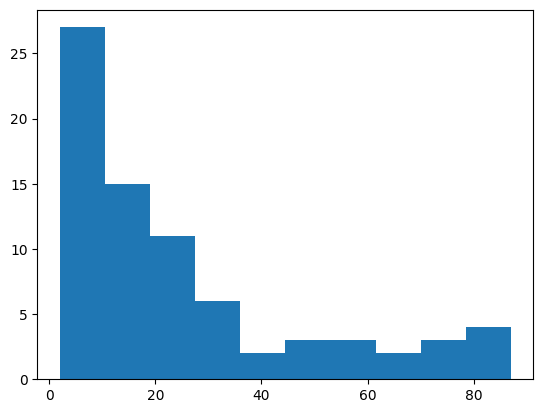

In [22]:
counts = df['group'].value_counts()
plt.hist(counts)

In [26]:
# Since the distribution is skewed, we separate the groups into four parts, and split each of them independently
# into train, validation, and test sets.
splits = [[], [], [], []]
for group, count in counts.items():
    if count <= 20:
        splits[0].append(group)
    elif count <= 40:
        splits[1].append(group)
    elif count <= 60:
        splits[2].append(group)
    else:
        splits[3].append(group)

In [37]:
train_groups = []
val_groups = []
test_groups = []

for split in splits:
    random.shuffle(split)
    length = len(split)
    train_length = int(length * (1 - val_ratio - test_ratio))
    val_length = int(length * val_ratio)
    test_length = int(length * test_ratio) 

    train = split[:train_length]
    val = split[train_length:train_length + val_length]
    test = split[train_length + val_length:]

    train_groups.extend(train)
    val_groups.extend(val)
    test_groups.extend(test)

In [38]:
len(train_groups)

51

In [39]:
len(val_groups)

10

In [41]:
def assign_split(group):
    if group in train_groups:
        return 'train'
    elif group in val_groups:
        return 'val'
    elif group in test_groups:
        return 'test'
    else:
        return 'error'

df['type'] = df['group'].apply(assign_split)

In [44]:
df.to_csv('data/acm_ccs_clean.csv', index=None)